# Import Libraries

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from xgboost import plot_importance as xgb_plot_importance
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR, LinearSVR

In [4]:
trips_df = pd.read_csv('all_trips.csv')

In [5]:
trips_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   trip_id              89 non-null     int64  
 1   duration_min         89 non-null     float64
 2   mean_speed           89 non-null     float64
 3   mean_acceleration    89 non-null     float64
 4   max_acceleration     89 non-null     float64
 5   mean_weight          89 non-null     float64
 6   elev_gain            89 non-null     float64
 7   distance_travelled   89 non-null     float64
 8   total_fuel_used_lit  89 non-null     float64
 9   lit_per_100km        89 non-null     float64
 10  source               89 non-null     object 
 11  is_duplicate         89 non-null     bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 7.9+ KB


# Correlation Matrix

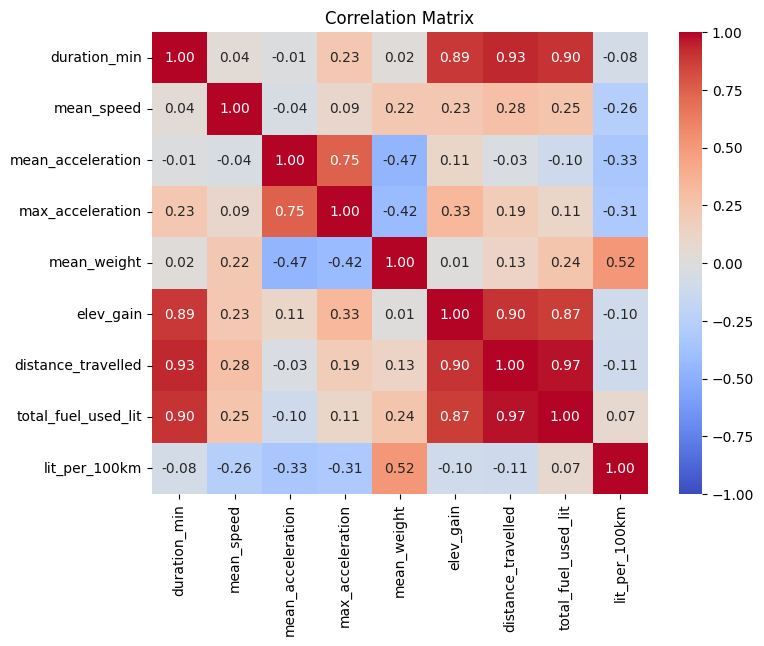

In [6]:
numerical_columns = ['duration_min', 'mean_speed', 'mean_acceleration', 'max_acceleration',
                     'mean_weight', 'elev_gain', 'distance_travelled', 'total_fuel_used_lit',
                     'lit_per_100km']

correlation_matrix = trips_df[numerical_columns].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

# MAE for single type of Trips (Short, Long)

In [7]:
for source in ['30min', '2hr']:
    subset = trips_df[trips_df['source'] == source]

    if len(subset) < 5:
        print(f"Skipping {source} — too few samples ({len(subset)}).")
        continue

    X = subset[['duration_min', 'mean_speed', 'mean_acceleration', 'max_acceleration',
                'mean_weight', 'elev_gain', 'distance_travelled']]
    y = subset['total_fuel_used_lit']

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', RandomForestRegressor(n_estimators=50, random_state=42))
    ])

    scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_absolute_error')
    print(f"{source} MAE:", -np.mean(scores))

30min MAE: 10.728597838827834
2hr MAE: 28.625612933333333


# Misc functions (Training & Plotting)

In [8]:
def plot_feature_distributions(X_train, X_test, y_train, y_test, feature_cols, target_col, source_col=None):
    if source_col:
      print(f"\nSource distribution by '{source_col}':")
      print("Train:")
      print(X_train[source_col].value_counts(normalize=True).sort_index())
      print("\nTest:")
      print(X_test[source_col].value_counts(normalize=True).sort_index())


    plt.figure(figsize=(5, 3))
    sns.histplot(y_train, color='blue', label='Train', stat='density', bins=30)
    sns.histplot(y_test, color='red', label='Test', stat='density', bins=30)
    plt.title(f'Distribution of Target ({target_col}) in Train vs Test')
    plt.legend()
    plt.show()

In [9]:
def train_and_evaluate(trips, feature_cols, target_col, name, model_tuple, test_size=0.2, random_state=42, source_col=None):
    model, param_grid = model_tuple
    X = trips[feature_cols].copy()
    y = trips[target_col]

    if source_col:
        source = trips[source_col]
    else:
        source = None

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state,
        stratify=source if source_col else None
    )

    #Take the csv of the test data for the final Optimization part
    test_data = X_test.copy()
    test_data[target_col] = y_test.values
    test_data["split"] = "test"
    test_data.to_csv("test_data.csv", index=False)

    # Combine and export train set
    train_data = X_train.copy()
    train_data[target_col] = y_train.values
    train_data["split"] = "train"

    # Combine both for unified train_test_set
    full_data = pd.concat([train_data, test_data], axis=0).reset_index(drop=True)
    full_data.to_csv("train_test_set.csv", index=False)


    if source_col:
        X_train[source_col] = trips.loc[X_train.index, source_col]
        X_test[source_col] = trips.loc[X_test.index, source_col]

    # plot_feature_distributions(X_train, X_test, y_train, y_test,
    #                            feature_cols, target_col)

    if source_col:
        X_train = X_train.drop(columns=[source_col])
        X_test = X_test.drop(columns=[source_col])

    # Normalize only if the model needs it
    models_needing_scaling = (LinearRegression, Ridge, Lasso, ElasticNet, SVR, LinearSVR)
    if isinstance(model, models_needing_scaling):
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', model)
        ])
        # Adjust param grid for pipeline
        param_grid = {f'regressor__{k}': v for k, v in param_grid.items()}
        estimator = pipeline
    else:
        estimator = model

    #Grid Search
    grid_search = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=0,
        error_score='raise'
    )

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print('\n')
    print(100*'-')
    print('NEW MODEL'.center(100))
    print(100*'-')
    print('\n')

    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"{name} MAE: {mae:.4f}")
    print(f"{name} R^2: {r2:.4f}")


    plot_actual_vs_predicted(y_test, y_pred, name)

    final_model = best_model.named_steps['regressor'] if isinstance(best_model, Pipeline) else best_model
    plot_feature_importance(final_model, feature_cols, name)

    return mae

In [10]:
def plot_feature_importance(best_model, feature_cols, name,colors ='#8DA0CB'):
    plt.figure(figsize=(8, 4))

    #XGBoost
    if isinstance(best_model, xgb.XGBRegressor):
        xgb.plot_importance(best_model, importance_type='gain', xlabel='Average Gain', height=0.5, grid=False, values_format="{v:.0f}",
                            color=colors if colors else 'C0')
        plt.title(f'{name}: Feature Importance (XGBoost)')

    #Models with Feature importances
    elif hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
        indices = np.argsort(importances)[::-1]
        feature_names = np.array(feature_cols)[indices]
        bar_colors = colors if colors else sns.color_palette("Set2", len(feature_names))
        plt.barh(feature_names, importances[indices], height=0.5, color=bar_colors)
        plt.xlabel('Feature Importance')
        plt.title(f'{name}: Feature Importance')

    #Models with coef
    elif hasattr(best_model, 'coef_'):
        importances = np.abs(best_model.coef_)
        indices = np.argsort(importances)[::-1]
        feature_names = np.array(feature_cols)[indices]
        bar_colors = colors if colors else sns.color_palette("Set2", len(feature_names))
        plt.barh(feature_names, importances[indices], height=0.5, color=bar_colors)
        plt.xlabel('Coefficient Magnitude (Absolute)')
        plt.title(f'{name}: Coefficient-Based Importance')
    else:
        print(f"Model {name} does not support feature importances.")
        return

    plt.tight_layout()
    plt.show()

In [11]:
def plot_actual_vs_predicted(y_test, y_pred, name):
    indices = range(len(y_test))
    plt.figure(figsize=(5, 3))
    plt.plot(indices, y_test, color='#66C2A5', label='Actual', lw=2)
    plt.plot(indices, y_pred, color='orange', label='Predicted', lw=2)
    plt.title(f'{name}: Actual vs Predicted')
    plt.xlabel('Example')
    plt.ylabel('Fuel Used (liters)')
    plt.legend(loc='upper left')
    plt.grid(False)
    plt.tight_layout()
    plt.show()

In [12]:
def plot_mae_comparison(results):

    sorted_results = dict(sorted(results.items(), key=lambda item: item[1]))
    model_names = list(sorted_results.keys())
    mae_values = [sorted_results[model] for model in model_names]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(model_names, mae_values, color = sns.color_palette("Set2", len(model_names)))
    plt.title('MAE Comparison Across Models', fontsize=14)
    plt.ylabel('Mean Absolute Error', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)

    for bar, mae in zip(bars, mae_values):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, f'{mae:.2f}', ha='center', va='bottom', fontsize=9)
    plt.ylim(0, max(mae_values) * 1.15)
    plt.tight_layout()
    plt.show()

# Machine Learnimg Models

In [13]:
algorithms = {
    'Random Forest': (
        RandomForestRegressor(random_state=42),
        {
          'n_estimators': [100, 200],
          'max_depth': [10, 20],
          'min_samples_split': [2, 5],
          'min_samples_leaf': [1, 2],
          'max_features': ['sqrt', 'log2']
        }
    ),
    'XGBoost': (
        xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
        {
          'n_estimators': [50, 100],
          'max_depth': [3, 5, 7],
          'learning_rate': [0.01, 0.1, 0.2]
        }
    ),
     'Ridge Regression': (
        Ridge(),
        {
            'alpha': [0.01, 0.1, 1.0, 10.0]
        }
    ),
    'Lasso Regression': (
        Lasso(max_iter=10000),
        {
            'alpha': [0.01, 0.1, 1.0, 10.0]
        }
    ),
    'Gradient Boosting': (
        GradientBoostingRegressor(random_state=42),
        {
          'n_estimators': [100, 200],
          'learning_rate': [0.05, 0.1],
          'max_depth': [3, 5, 7]
        }
    ),
    'SVR': (
    LinearSVR(),
    {

        'C': [0.1, 1],
        'epsilon': [0.01, 0.1],
        'max_iter': [1000,5000]

    }
),
    'Decision Tree': (
    DecisionTreeRegressor(random_state=42),
    {
        'max_depth': [3, 5, 10, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    ),
    'Linear Regression': (
        LinearRegression(),
        {}
    ),
     'Elastic Net': (
        ElasticNet(max_iter=10000),
        {
            'alpha': [0.01, 0.1, 1.0],
            'l1_ratio': [0.2, 0.5, 0.8]
        }
    )
}


feature_cols = ['duration_min', 'mean_speed', 'mean_acceleration', 'max_acceleration',
                'mean_weight', 'elev_gain', 'distance_travelled']
source_col = 'source'
target_col_total_fuel = 'total_fuel_used_lit'
target_col_lit_per_100km = 'lit_per_100km'



----------------------------------------------------------------------------------------------------
                                             NEW MODEL                                              
----------------------------------------------------------------------------------------------------


Best parameters for Random Forest: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest MAE: 9.9999
Random Forest R^2: 0.9553


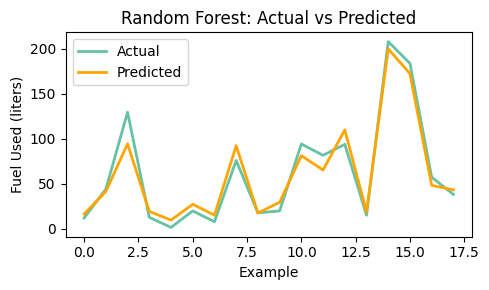

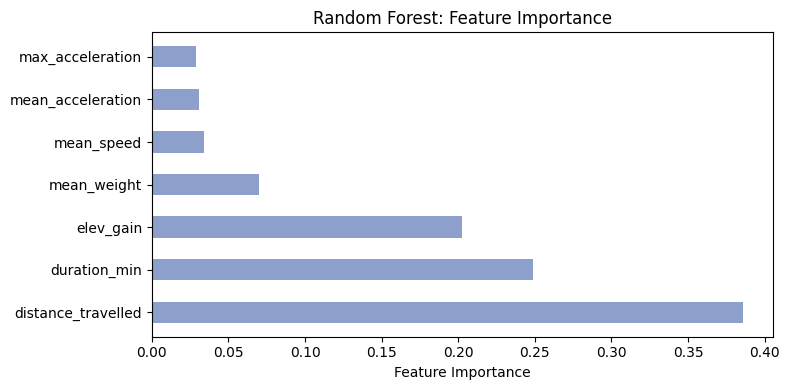



----------------------------------------------------------------------------------------------------
                                             NEW MODEL                                              
----------------------------------------------------------------------------------------------------


Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
XGBoost MAE: 10.1838
XGBoost R^2: 0.9492


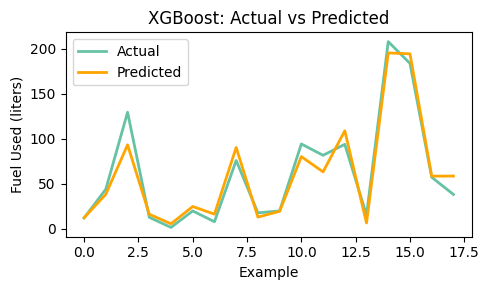

<Figure size 800x400 with 0 Axes>

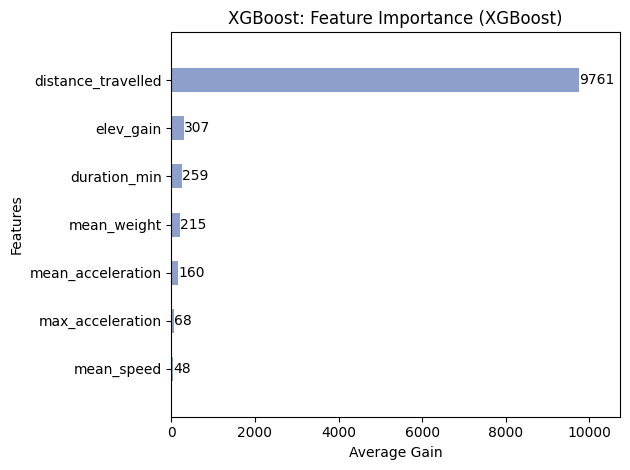



----------------------------------------------------------------------------------------------------
                                             NEW MODEL                                              
----------------------------------------------------------------------------------------------------


Best parameters for Ridge Regression: {'regressor__alpha': 0.01}
Ridge Regression MAE: 7.0576
Ridge Regression R^2: 0.9731


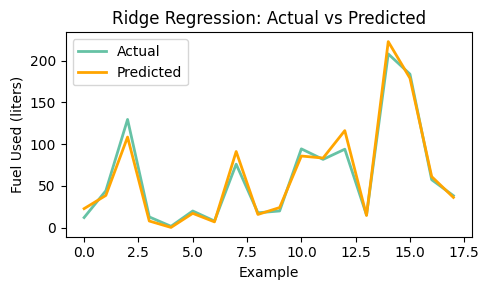

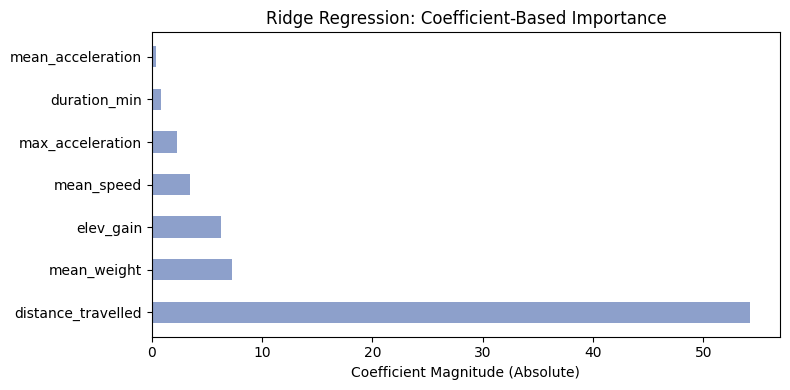



----------------------------------------------------------------------------------------------------
                                             NEW MODEL                                              
----------------------------------------------------------------------------------------------------


Best parameters for Lasso Regression: {'regressor__alpha': 0.1}
Lasso Regression MAE: 6.8593
Lasso Regression R^2: 0.9740


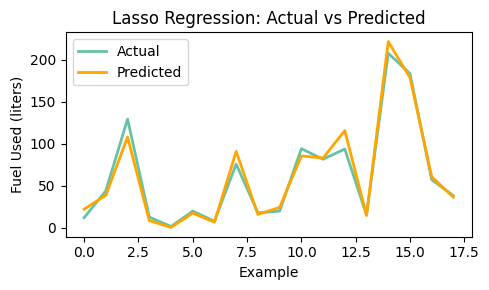

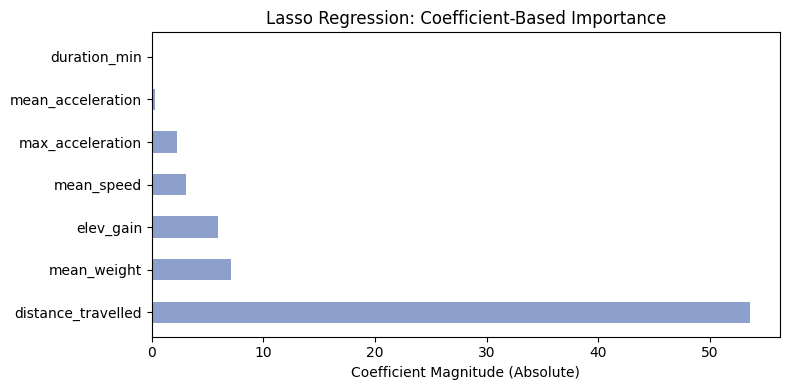



----------------------------------------------------------------------------------------------------
                                             NEW MODEL                                              
----------------------------------------------------------------------------------------------------


Best parameters for Gradient Boosting: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
Gradient Boosting MAE: 10.2234
Gradient Boosting R^2: 0.9534


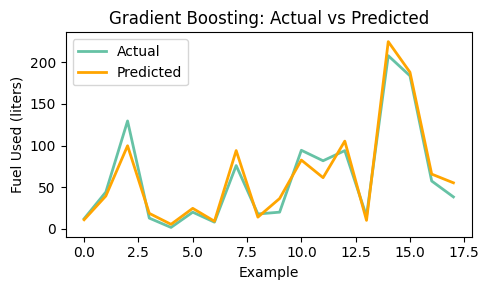

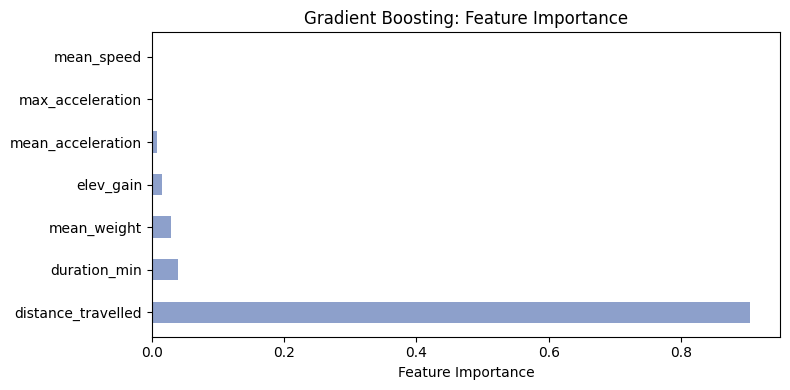



----------------------------------------------------------------------------------------------------
                                             NEW MODEL                                              
----------------------------------------------------------------------------------------------------


Best parameters for SVR: {'regressor__C': 1, 'regressor__epsilon': 0.1, 'regressor__max_iter': 1000}
SVR MAE: 19.1802
SVR R^2: 0.7576


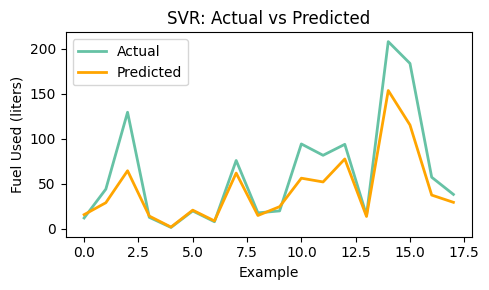

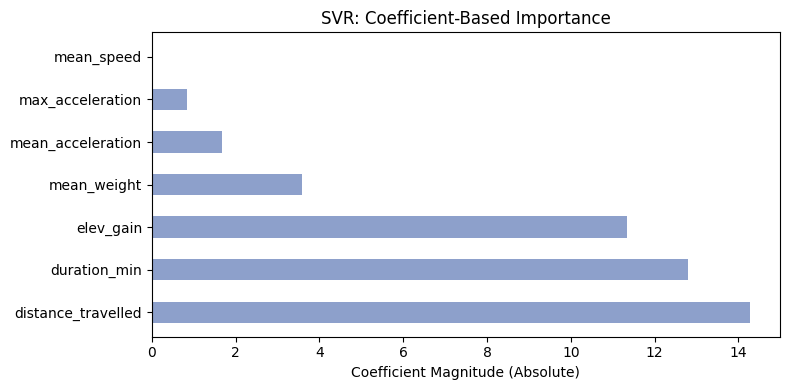



----------------------------------------------------------------------------------------------------
                                             NEW MODEL                                              
----------------------------------------------------------------------------------------------------


Best parameters for Decision Tree: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}
Decision Tree MAE: 14.4084
Decision Tree R^2: 0.8978


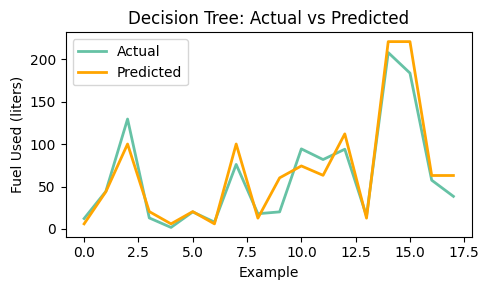

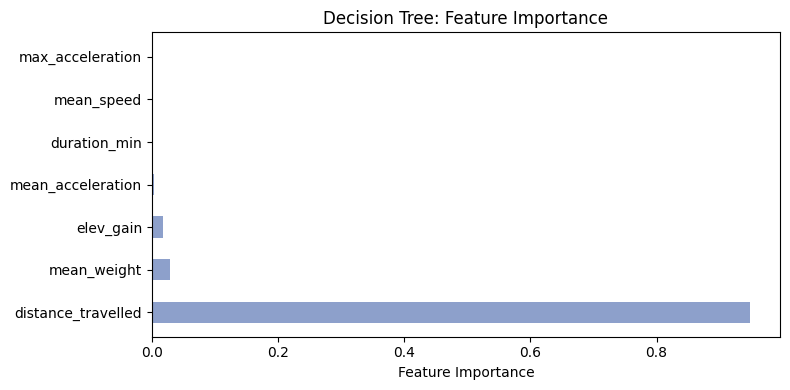



----------------------------------------------------------------------------------------------------
                                             NEW MODEL                                              
----------------------------------------------------------------------------------------------------


Best parameters for Linear Regression: {}
Linear Regression MAE: 7.0668
Linear Regression R^2: 0.9731


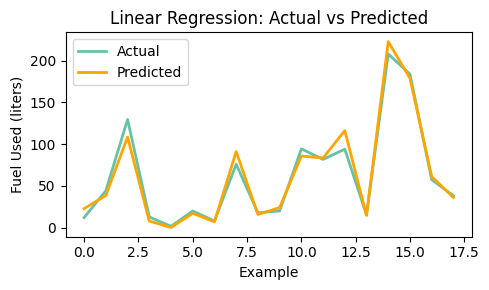

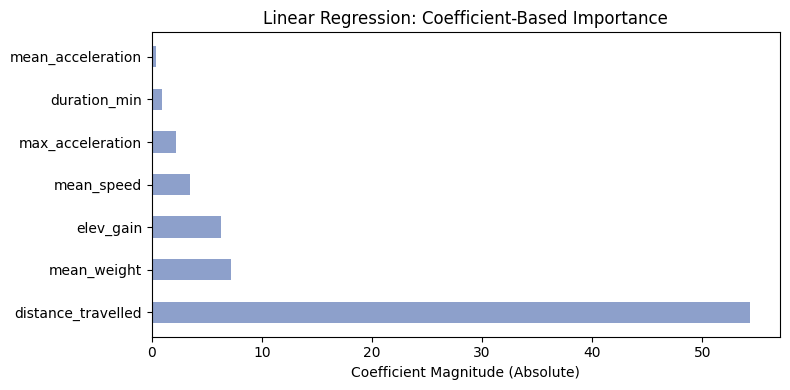



----------------------------------------------------------------------------------------------------
                                             NEW MODEL                                              
----------------------------------------------------------------------------------------------------


Best parameters for Elastic Net: {'regressor__alpha': 0.01, 'regressor__l1_ratio': 0.8}
Elastic Net MAE: 6.9305
Elastic Net R^2: 0.9734


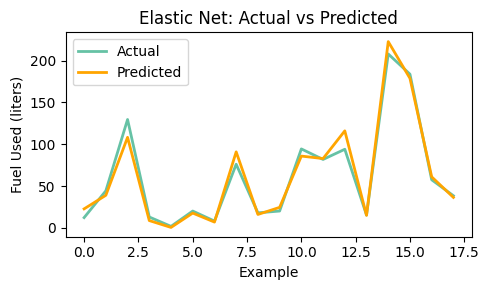

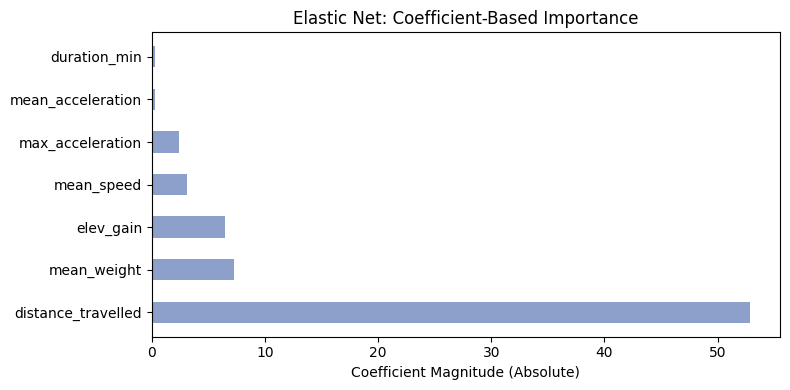

In [14]:
results_total_fuel = {}
for name, model in algorithms.items():
    mae = train_and_evaluate(
        trips_df,
        feature_cols,
        target_col_total_fuel,
        name,
        model,
        source_col = None
    )
    results_total_fuel[name] = mae

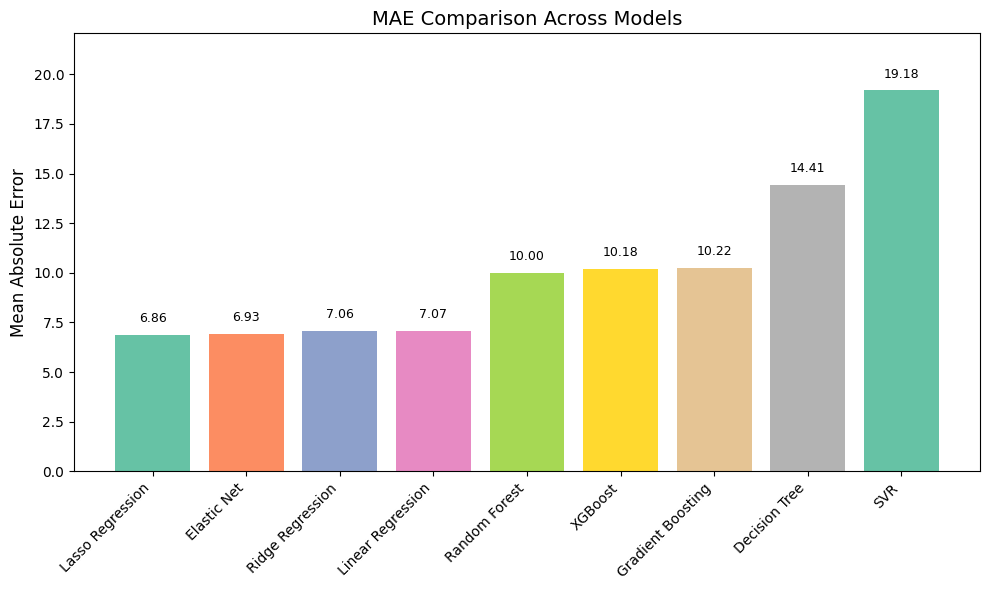

In [15]:
plot_mae_comparison(results_total_fuel)



----------------------------------------------------------------------------------------------------
                                             NEW MODEL                                              
----------------------------------------------------------------------------------------------------


Best parameters for Random Forest: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest MAE: 6.3875
Random Forest R^2: 0.2411


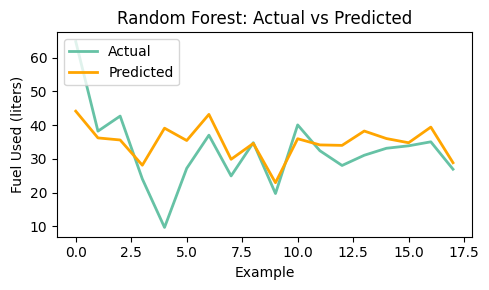

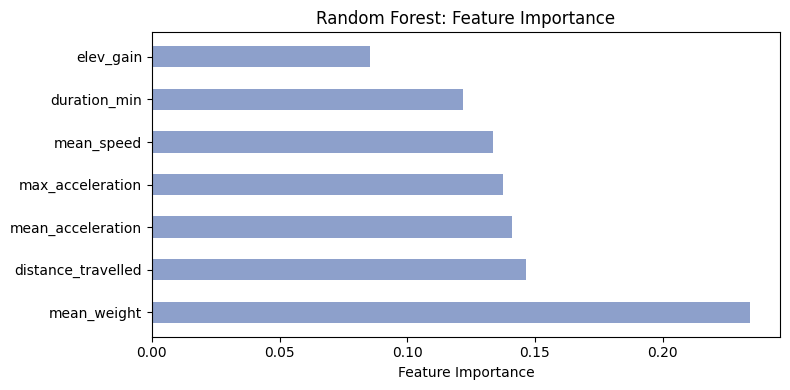



----------------------------------------------------------------------------------------------------
                                             NEW MODEL                                              
----------------------------------------------------------------------------------------------------


Best parameters for XGBoost: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100}
XGBoost MAE: 6.0728
XGBoost R^2: 0.1460


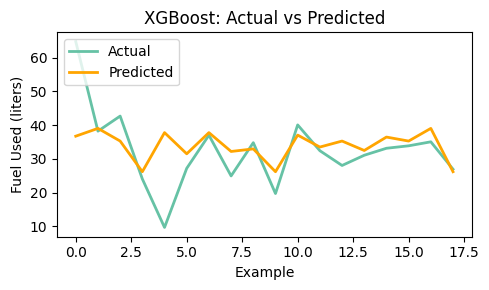

<Figure size 800x400 with 0 Axes>

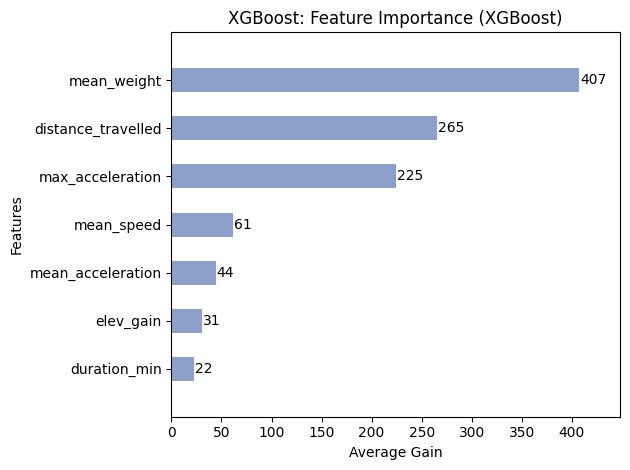



----------------------------------------------------------------------------------------------------
                                             NEW MODEL                                              
----------------------------------------------------------------------------------------------------


Best parameters for Ridge Regression: {'regressor__alpha': 10.0}
Ridge Regression MAE: 5.2409
Ridge Regression R^2: 0.4879


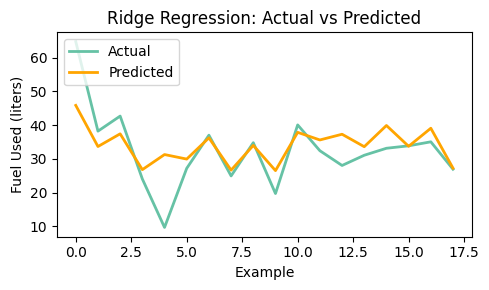

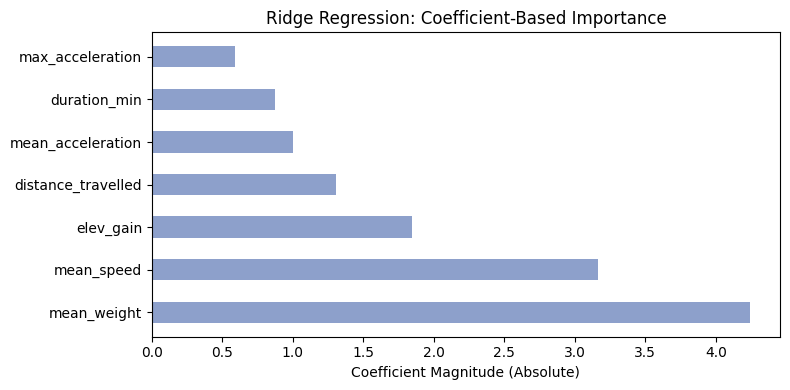



----------------------------------------------------------------------------------------------------
                                             NEW MODEL                                              
----------------------------------------------------------------------------------------------------


Best parameters for Lasso Regression: {'regressor__alpha': 0.1}
Lasso Regression MAE: 5.0715
Lasso Regression R^2: 0.5396


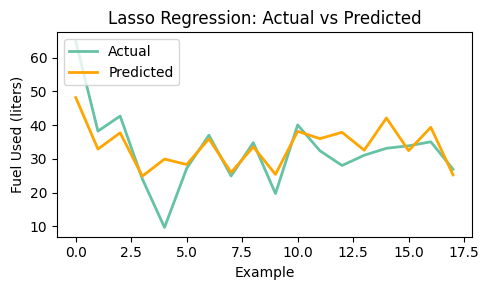

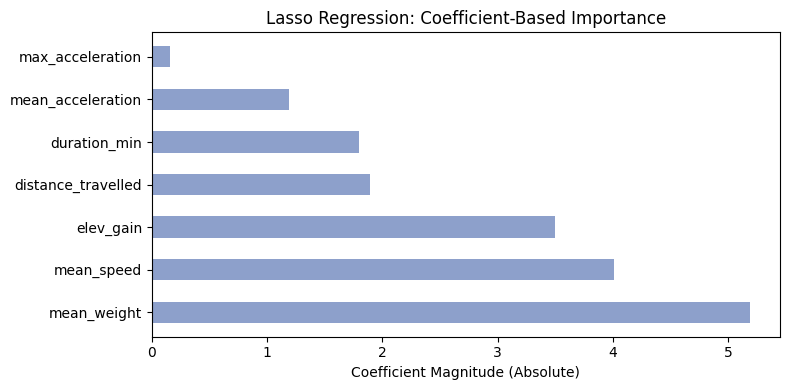



----------------------------------------------------------------------------------------------------
                                             NEW MODEL                                              
----------------------------------------------------------------------------------------------------


Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Gradient Boosting MAE: 5.1925
Gradient Boosting R^2: 0.3710


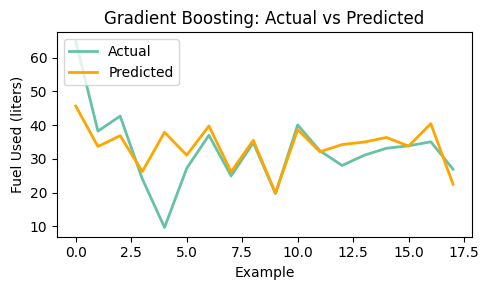

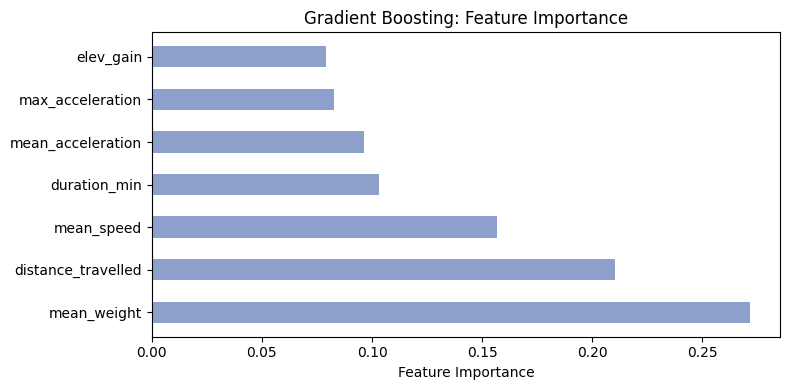



----------------------------------------------------------------------------------------------------
                                             NEW MODEL                                              
----------------------------------------------------------------------------------------------------


Best parameters for SVR: {'regressor__C': 1, 'regressor__epsilon': 0.01, 'regressor__max_iter': 1000}
SVR MAE: 6.3655
SVR R^2: 0.3741


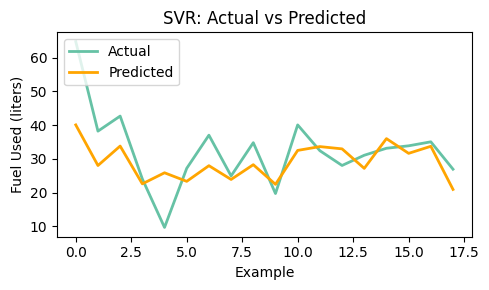

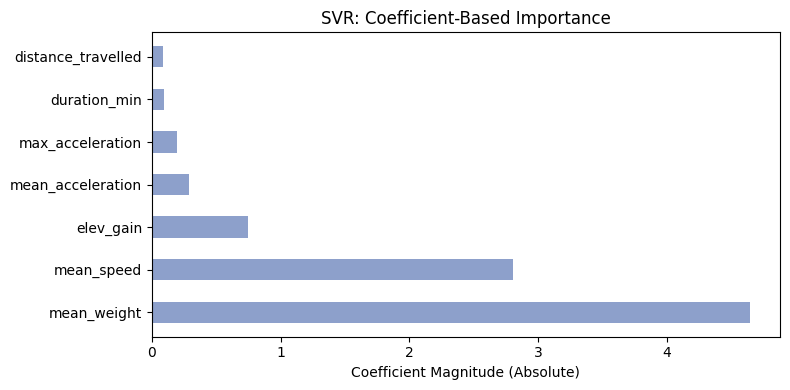



----------------------------------------------------------------------------------------------------
                                             NEW MODEL                                              
----------------------------------------------------------------------------------------------------


Best parameters for Decision Tree: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}
Decision Tree MAE: 8.0661
Decision Tree R^2: 0.0095


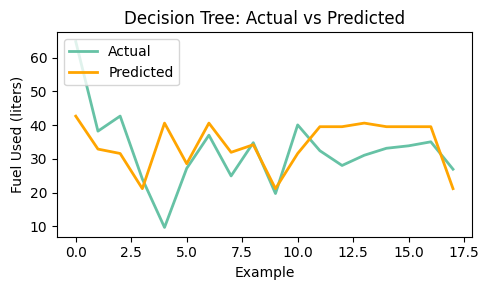

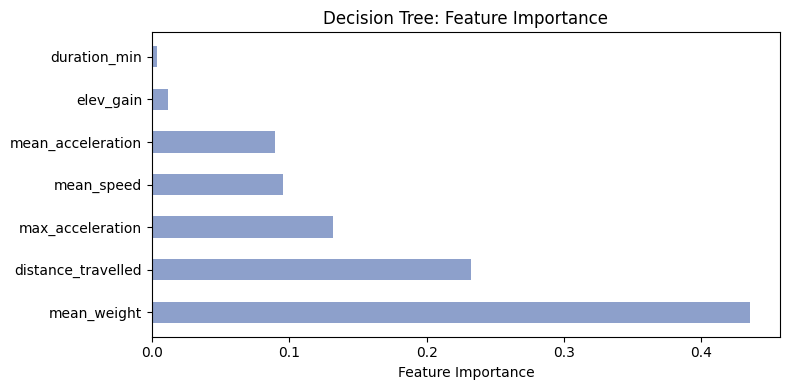



----------------------------------------------------------------------------------------------------
                                             NEW MODEL                                              
----------------------------------------------------------------------------------------------------


Best parameters for Linear Regression: {}
Linear Regression MAE: 5.0919
Linear Regression R^2: 0.5371


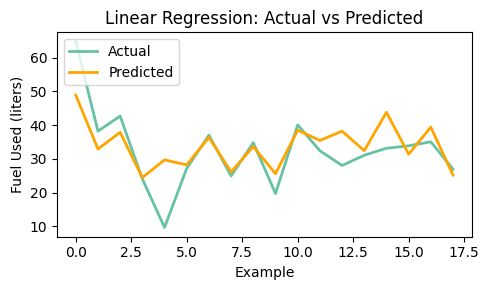

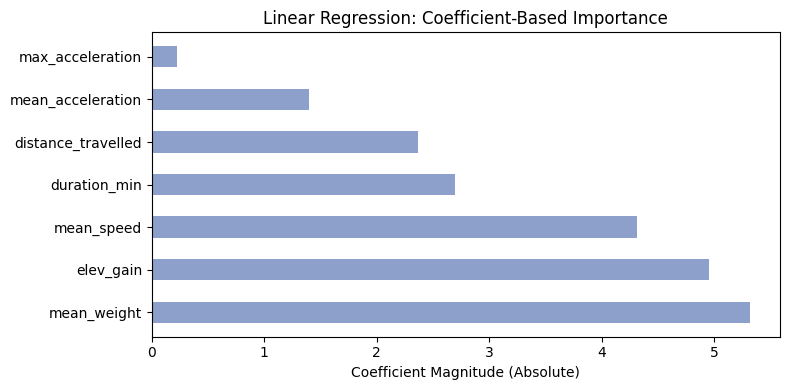



----------------------------------------------------------------------------------------------------
                                             NEW MODEL                                              
----------------------------------------------------------------------------------------------------


Best parameters for Elastic Net: {'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.2}
Elastic Net MAE: 5.1481
Elastic Net R^2: 0.5110


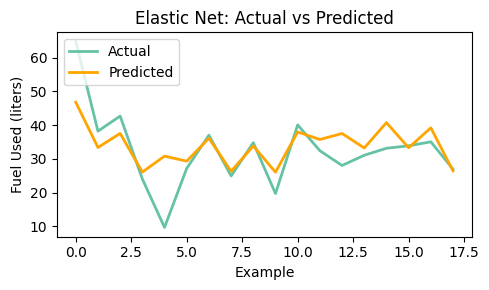

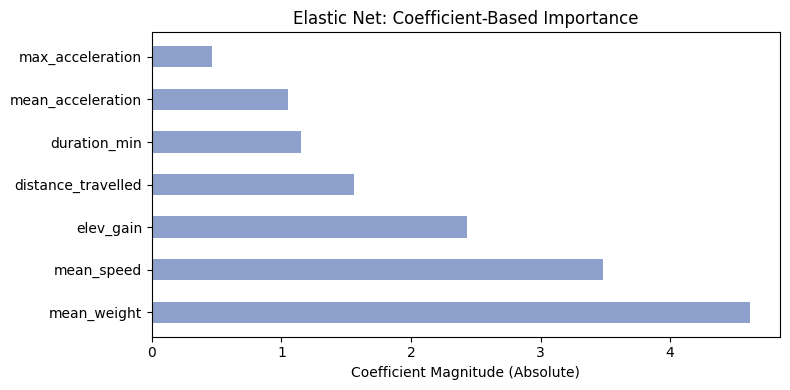

In [16]:
results_per_100km = {}
for name, model in algorithms.items():
    mae = train_and_evaluate(
        trips_df,
        feature_cols,
        target_col_lit_per_100km,
        name,
        model,
        source_col = None
    )
    results_per_100km[name] = mae

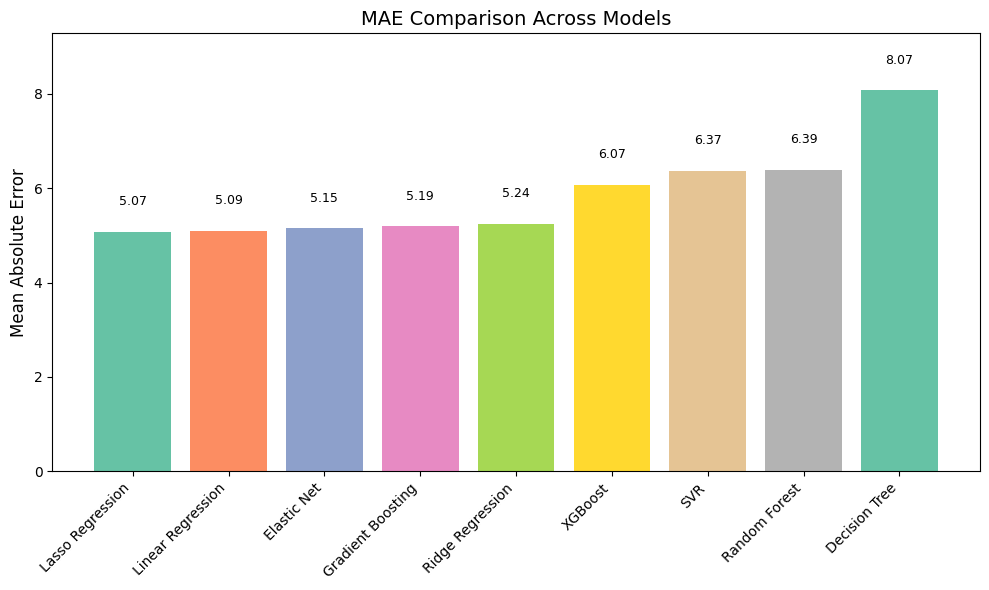

In [17]:
plot_mae_comparison(results_per_100km)